# 『Machine learning phases of matter』を理解したい
## 原著論文について

https://arxiv.org/abs/1605.01735

### Abstract

Neural networks can be used to identify phases and phase transitions in condensed matter systems via supervised machine learning.

Readily programmable through modern software libraries, we show that a standard feed-forward neural network can be trained to detect multiple types of order parameter directly from raw state configurations sampled with Monte Carlo. 

In addition, they can detect highly non-trivial states such as Coulomb phases, and if modified to a convolutional neural network, topological phases with no conventional order parameter. 

We show that this classification occurs within the neural network without knowledge of the Hamiltonian or even the general locality of interactions. 

These results demonstrate the power of machine learning as a basic research tool in the field of condensed matter and statistical physics.


ニューラルネットワークは、教師ありの機械学習によって、凝縮系における相や相転移を特定するために使用することができます。

最新のソフトウェアライブラリで容易にプログラム可能です、 

標準的なフィードフォワードニューラルネットワークを学習させることで、モンテカルロ法でサンプリングした生の状態構成から直接、複数種類のオーダーパラメータを検出できることを示すものです。

また、畳み込みニューラルネットワークに変更することで、従来の秩序変数のないトポロジカル相を検出することができます。

この分類は、ハミルトニアンや相互作用の一般的な局所性さえも知ることなく、ニューラルネットワーク内で行われることを示す。これらの結果は、物性物理学および統計物理学の分野における基礎研究ツールとして、機械学習の威力を示すものである。


## 1回目(6/7)：導入
簡単な平衡統計物理学の理解をしましょう．

### 調和振動
OUノイズは，調和振動子ポテンシャルに従うブラウン運動である．

チャップマン・コロモゴロフ方程式
$$
\frac{\partial p(x , t)}{\partial t} =  \frac{\partial (k x p(x , t))}{\partial x} +\frac{D}{2} \frac{\partial^2 p(x , t)}{\partial x^2}
$$

確率微分方程式
$$
dx = -kx\ dt+ \sqrt{D}\ dW(t)
$$

積分方程式
$$
x(t) = x(0) \exp{\{-kt\}} + \sqrt{D} \int_0^t \exp{\{-k(t-s)\}} dW(s)
$$

理論的な期待値
$$
E[x(t)] = x_0 \exp{\{-kt\}}
$$

理論的な分散
$$
Var[x(t)] = \frac{D}{2k} (1 - \exp{\{-2kt\}})
$$

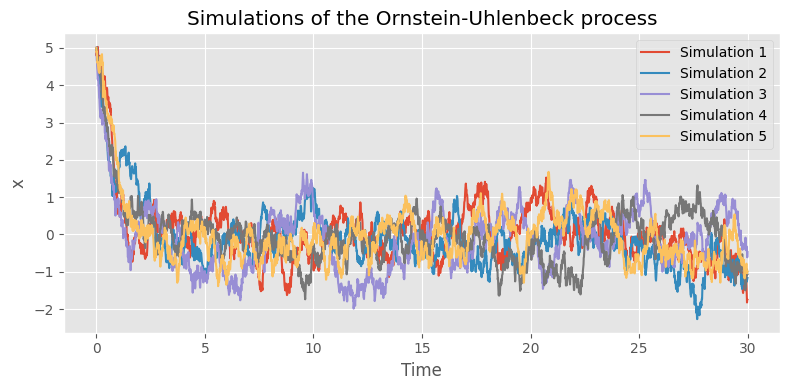

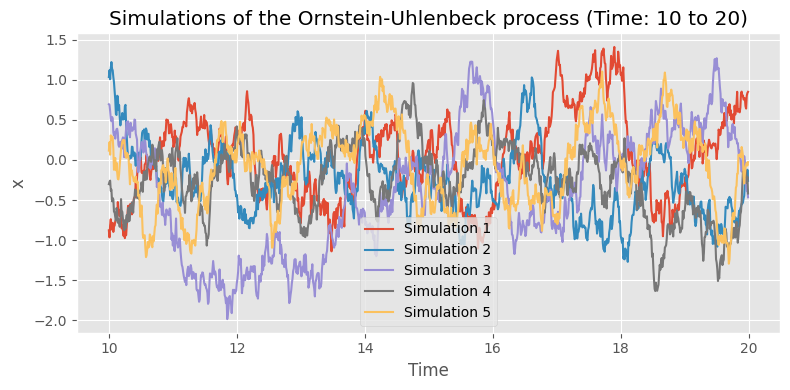

In [129]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# k = 1.0e-23# ボルツマン定数 

# パラメータの設定
k = 1.0  # ボルツマン定数 k
D = 1.0  # 温度のパラメータ D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 5.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列

# シミュレーションの繰り返し
num_simulations = 5  # シミュレーション回数
simulations = np.zeros((num_simulations, N))  # シミュレーション結果の配列

for i in range(num_simulations):
    x = np.zeros(N)  # xの値の配列
    x[0] = x0
    
    for j in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
        x[j+1] = x[j] - k * x[j] * dt + np.sqrt(D) * dW
        t[j+1] = t[j] + dt
    
    simulations[i] = x

# 元の0から観測時間までのプロット
plt.figure(figsize=(8, 4))
for i in range(num_simulations):
    plt.plot(t, simulations[i], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulations of the Ornstein-Uhlenbeck process')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 時間範囲の指定
t_start = 10.0
t_end = 20.0
start_index = int(t_start / dt)
end_index = int(t_end / dt)

# 時間指定したプロット
plt.figure(figsize=(8, 4))
for i in range(num_simulations):
    plt.plot(t[start_index:end_index], simulations[i, start_index:end_index], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulations of the Ornstein-Uhlenbeck process (Time: 10 to 20)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

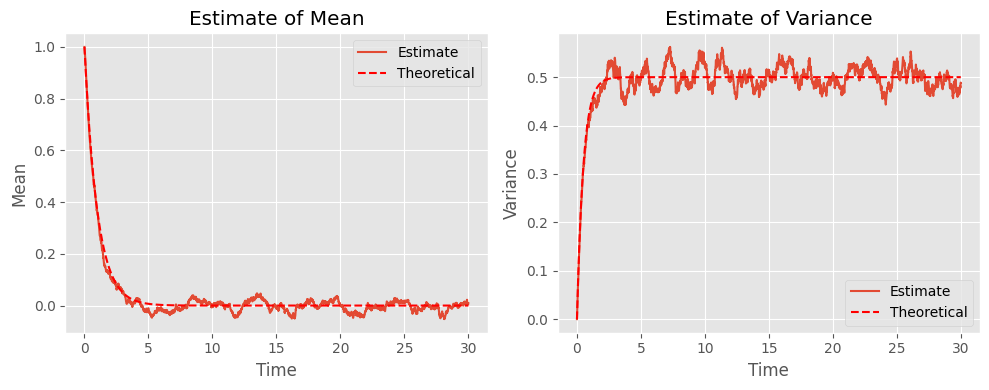

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
k = 1.0  # ボルツマン定数 k
D = 1.0  # 熱浴の温度定数 D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 1.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列

# シミュレーションの繰り返し
num_simulations = 1000  # シミュレーション回数
simulations = np.zeros((num_simulations, N))  # シミュレーション結果の配列

for i in range(num_simulations):
    x = np.zeros(N)  # xの値の配列
    x[0] = x0
    
    for j in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
        x[j+1] = x[j] - k * x[j] * dt + np.sqrt(D) * dW
        t[j+1] = t[j] + dt
    
    simulations[i] = x

# 期待値と分散の推定値の計算
mean_estimates = np.mean(simulations, axis=0)
variance_estimates = np.var(simulations, axis=0)

# 理論的な期待値と分散の計算
x_theoretical = x0 * np.exp(-k * t)
mean_theoretical = x0 * np.exp(-k * t)
variance_theoretical = (D / (2 * k)) * (1 - np.exp(-2 * k * t))

# グラフのプロット
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(t, mean_estimates, label='Estimate')
plt.plot(t, mean_theoretical, 'r--', label='Theoretical')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.title('Estimate of Mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, variance_estimates, label='Estimate')
plt.plot(t, variance_theoretical, 'r--', label='Theoretical')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Estimate of Variance')
plt.legend()

plt.tight_layout()
plt.show()

### 2粒子系

ハミルトニアンが与えられたとき，その系の状態は以下のようなボルツマン分布に従います．
$$
P[C] = \frac{1}{Z} e^{-\beta E[C]}
$$

具体的にハミルトニアンを以下のように設定します．$s_i = \{ -1 , + 1 \}$として
$$
E[C] = -J s_1 s_2 -h (s_1 + s_2)
$$

$h$は外部磁場，$J$ は相互作用の強さを表します．

$s_1 , s_2$の組み合わせは$2^2$通りあり，それぞれにボルツマン分布に従った確率が定義されます．
$$
P[C] = \frac{1}{Z} e^{-\beta \{ -J s_1 s_2 -h (s_1 + s_2)\}}
$$

ここで知りたいのは，『磁石としての強さ』です．
$$
m[C] = \frac{1}{2} \sum_i s_i
$$

この磁化率も確率変数です．

期待値は
$$
\langle m \rangle = \sum_C m[C] P[C]
$$

これを計算すると
$$
\langle m \rangle = \frac{1}{Z} \sum_C m[C] e^{-\beta E[C]}
$$

となります．

以上のことを実際に実装してみましょう．

In [131]:
import numpy as np

#k = 1.380649 * 10**(-23) # Boltzmann constant

$$
E[C] = -J s_1 s_2 -h (s_1 + s_2)
$$

In [132]:
# ハミルトニアンの定義
def test_hamiltonian(J , h , s):
    s1 = s[0]
    s2 = s[1]
    return -J * s1 * s2 - h * (s1 + s2)

$$
P[C] = \frac{1}{Z} e^{-\beta \{ -J s_1 s_2 -h (s_1 + s_2)\}}
$$

In [133]:
# ボルツマン分布（分子）の定義
def test_boltzmann(J , h , s , T):
    k = 1
    s1 = s[0]
    s2 = s[1]
    beta = 1 / (k * T)
    return np.exp(-beta * test_hamiltonian(J , h , s) )

In [134]:
# 分配関数の定義
def test_partition(J , h , T):
    k = 1
    beta = 1 / (k * T) 
    return np.exp(beta * (J + 2 * h)) + np.exp(beta * (J - 2 * h)) + 2 * np.exp(-beta * J)

In [135]:
# ボルツマン分布の定義
def test_boltzmann_factor(J , h , s , T):
    return test_boltzmann(J , h , s , T) / test_partition(J , h , T)

In [136]:
# すべての配列を定義
s1 = np.array([1 , 1])
s2 = np.array([1 , -1])
s3 = np.array([-1 , 1])
s4 = np.array([-1 , -1])

In [137]:
# パラメータ
J = 1
h = 0.5
T = 1

test_boltzmann_factor(J , h , s1 , T) , test_boltzmann_factor(J , h , s2 , T) , test_boltzmann_factor(J , h , s3 , T) , test_boltzmann_factor(J , h , s4 , T)

(0.809775991523652,
 0.04031637265264287,
 0.04031637265264287,
 0.10959126317106233)

In [138]:
# すべての可能性の和
test_boltzmann_factor(J , h , s1 , T) + test_boltzmann_factor(J , h , s2 , T) + test_boltzmann_factor(J , h , s3 , T)  + test_boltzmann_factor(J , h , s4 , T)

1.0

$$
m[C] = \frac{1}{2} \sum_i s_i
$$


In [139]:
# 磁化率の定義
def test_magnetization(s):
    return np.sum(s) / len(s)

In [140]:
test_magnetization(s1) , test_magnetization(s2) , test_magnetization(s3) , test_magnetization(s4)

(1.0, 0.0, 0.0, -1.0)

$$
\langle m \rangle = \sum_C m[C] P[C]
$$
つまり
$$
\langle m \rangle = \frac{1}{Z} \{ \exp(\beta(J+2h)) - \exp(\beta(J-2h)) \}
$$

In [141]:
# 磁化率の期待値
def test_magnetization_expectation(J , h , T):
    beta = 1 / T
    return (np.exp(beta *(J + 2*h)) - np.exp(beta * (J - 2*h)) ) / test_partition(J , h , T)

In [142]:
test_magnetization_expectation(J , h , T)

0.7001847283525897

磁化率の期待値に対して，パラメータを変化させたときの推移をグラフ化しましょう．

In [143]:
import matplotlib.pyplot as plt

温度を変えてみる

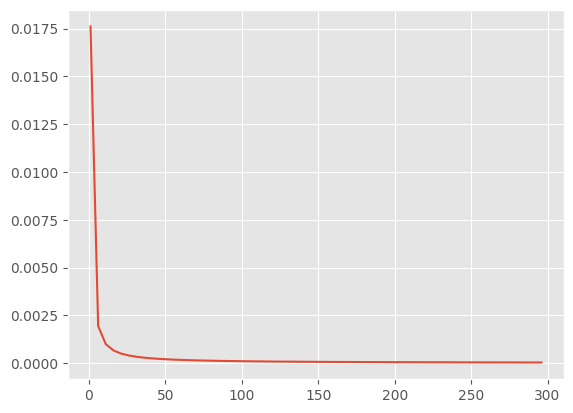

In [144]:
# J , h 固定
# Tを変えてみる
# パラメータ
J = 1
h = 0.01
T = np.arange(1 , 300 , 5)
magnetization_expectation = np.array([test_magnetization_expectation(J , h , t) for t in T])
plt.plot(T , magnetization_expectation)

相互作用を変えてみる


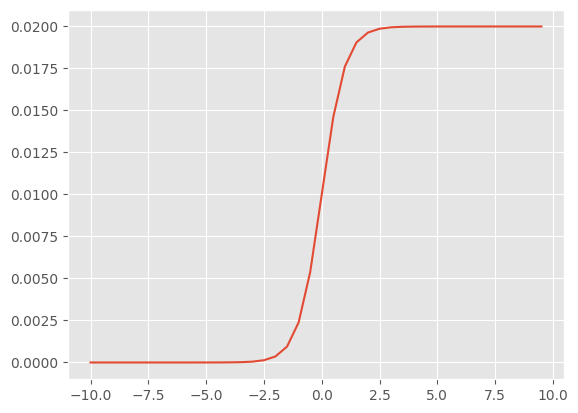

In [145]:
# h , T 固定
# Jを変えてみる
h = 0.01
T = 1
J = np.arange(-10 ,10 ,  0.5)
magnetization_expectation = np.array([test_magnetization_expectation(j , h , T) for j in J])
plt.plot(J , magnetization_expectation)

外部磁場を変えてみる

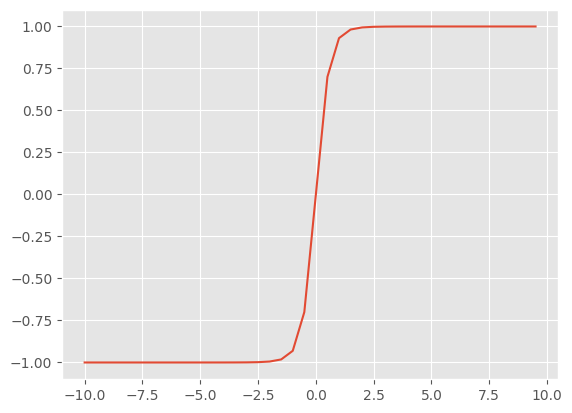

In [146]:
# J , T 固定
# hを変えてみる
J = 1
T = 1
h = np.arange(-10 , 10 , 0.5)
magnetization_expectation = np.array([test_magnetization_expectation(J , hh , T) for hh in h])
plt.plot(h , magnetization_expectation)


### 1次元イジング模型
$L$個の粒子からなる1次元イジング模型を考えます．
$$
E[C] = -J \sum^{L-1}_{i=1} s_i s_{i+1} -h \sum^{L}_{i=1} s_i
$$
平均場近似を用いると相転移の様子がわかる．

具体的には以下の交点が解となる．
$$
y=m\  ,\  y = \tanh(2\beta m +\beta h)
$$

ここでは横軸$m$，縦軸$y$として様々なパラメータの様子をプロットしてみる．

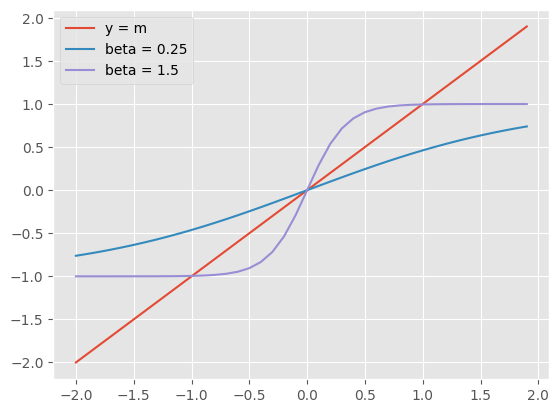

In [147]:
h = 0
beta1 = 0.25
beta2 = 1.5

m = np.arange(-2.0 , 2.0 , 0.1)
y1 = m
y2 = np.tanh(2*beta1 * m)
y3 = np.tanh(2*beta2 * m)

plt.plot(m , y1 , label = "y = m")
plt.plot(m , y2 , label = "beta = 0.25")
plt.plot(m , y3 , label = "beta = 1.5")
plt.legend()

## 2回目(6/14)：『これならわかる機械学習入門』10章

https://www.amazon.co.jp/%E3%81%93%E3%82%8C%E3%81%AA%E3%82%89%E3%82%8F%E3%81%8B%E3%82%8B%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E5%85%A5%E9%96%80-KS%E7%89%A9%E7%90%86%E5%B0%82%E9%96%80%E6%9B%B8-%E5%AF%8C%E8%B0%B7-%E6%98%AD%E5%A4%AB/dp/4065225493

この教科書は，『Machine learning phases of matter』の前半部分を理解するために機械学習の入門的な内容を優しく扱った本です．

まずはこの本の実装を忠実に再現し，論文理解への橋渡しをします．


## MCMC法

### モンテカルロ法
モンテカルロ法は，乱数を用いて積分や和を求める計算手法です．

今回は磁化率の期待値を求めたいので，モンテカルロ法が適しています．

乱数の発生規則は，ボルツマン分布に従うということから
$$
P[C] = \frac{1}{Z} e^{-\beta E[C]}
$$
から乱数を発生させれば良いのですが，やはり分配関数の計算が大変です．

そこで分配関数を直接計算せずに，シミュレーションを行える方法が次に説明するマルコフ連鎖モンテカルロ法です．

### マルコフ連鎖モンテカルロ法
期待値は一般に以下のように書けます．
$$
\langle f \rangle = \sum_C f[C] P[C]
$$

これを近似的に計算するために，以下のような方法を考えます．
$$
\langle f \rangle \simeq \frac{1}{N} \sum^{N}_{i=1} f[C_i]
$$

もちろん，適当に生成する正しい期待値へと収束しないので，詳細釣り合い条件を用いて生成します．
$$
P[C_a|C_b] P[C_b] = P[C_b|C_a] P[C_a]
$$

これを用いたアルゴリズムがマルコフ連鎖モンテカルロ法です．

### MH法
MH法は，マルコフ連鎖モンテカルロ法の一種です．

ある配列$C_a$から別の配列$C_b$を生成するアルゴリズムを考えます．

$C_a$のほうが$C_b$よりもエネルギーが高い場合，つまり，$E[C_a] > E[C_b]$の場合は$C_a$のほうが安定であるから

$P[C_a|C_b]=1$より，詳細釣り合いの式に代入すると
$$
P[C_b|C_a] = \frac{P[C_a|C_b] P[C_b]}{P[C_a]} = \frac{P[C_b]}{P[C_a]}
$$

ボルツマン分布を使うと
$$
P[C_b|C_a] = \frac{e^{-\beta E[C_b]}}{e^{-\beta E[C_a]}} = e^{-\beta (E[C_b] - E[C_a])}
$$
となります．

この事実を利用してサンプリングする方法をMH法と呼びます．

## ギブスサンプリング（熱浴法）

着目する粒子以外を熱浴とみなして状態を固定し，影響されうる着目した粒子の変化を詳細釣り合い条件に従って確率的に生成します．

$A = A_j$を粒子$j$の状態とし，$B$をそれ以外の粒子の状態とします．その同時分布はボルツマン分布に従うとして
$$
P[A,B] = \frac{1}{Z} e^{-\beta E[A,B]} = \frac{1}{Z} \exp { \left\{\beta J s_j \sum_{k \in N(j)}s_k + \beta h s_j+ (S_jを除く項)\right\}}
$$

ここで，$N(j)$は粒子$j$に隣接する粒子の集合です．

このとき，$B$のみの分布は，同時分布を周辺化して
$$
P[B] = \sum_{s_j=\pm 1}  P[A,B] = \frac{1}{Z} \exp { \left\{ (S_jを除く項)\right\}} \sum_{s_j=\pm 1} \exp { \left\{\beta J s_j \sum_{k \in N(j)}s_k + \beta h s_j\right\}}
$$

したがって条件付き確率$P[A|B]$は
$$
P[A|B] = \frac{P[A,B]}{P[B]} = \exp { \left\{\beta J s_j \sum_{k \in N(j)}s_k + \beta h s_j \right\}} \left/ \sum_{s_j=\pm 1} \exp { \left\{\beta J s_j \sum_{k \in N(j)}s_k + \beta h s_j\right\}} \right.
$$

これによって，分配関数を計算することなく，条件付き確率を計算することができます．

また，注目している粒子以外の情報は，隣接している部分のみとなります．

4×4の正方格子を例に実装を試してみましょう．

In [148]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [149]:
def test_lattice():
    lattice = np.array([[-1,1,1,-1],
                        [1,1,1,1],
                        [1,1,1,-1],
                        [-1,1,-1,-1]])
    return lattice

lattice = test_lattice()

In [150]:
latice = test_lattice()

print(lattice)

[[-1  1  1 -1]
 [ 1  1  1  1]
 [ 1  1  1 -1]
 [-1  1 -1 -1]]


最初の磁化率を計測しておきましょう．

復習のため磁化率を記載しておきます．
$$
m[C] = \frac{1}{|C|} \sum_i s_i
$$

In [151]:
# 磁化率の計算
def compute_magnetization(lattice):
    N  = lattice.shape[0] * lattice.shape[1]
    magnetization = np.sum(lattice) / N
    return magnetization

m = compute_magnetization(lattice)
print(f"磁化率: {m}")

磁化率: 0.25


分母の注目する粒子と隣接する粒子の状態和を計算します．
$$
\sum_{k \in N(j)}s_k
$$

In [152]:
# 隣接サイトの情報を取得し総和を取る，row:行，col:列

def compute_neighbor_sum(lattice, row, col):
    n = lattice.shape[0]  # 正方格子の一辺の長さ
    neighbor_sum = 0
    
    # 上方向の隣接要素の総和
    if row > 0:
        neighbor_sum += lattice[row-1, col]
    
    # 下方向の隣接要素の総和
    if row < n-1:
        neighbor_sum += lattice[row+1, col]
    
    # 左方向の隣接要素の総和
    if col > 0:
        neighbor_sum += lattice[row, col-1]
    
    # 右方向の隣接要素の総和
    if col < n-1:
        neighbor_sum += lattice[row, col+1]
    
    return neighbor_sum


print("二次元正方格子:")
print(lattice)

row = 1
col = 1
sum_of_neighbors = compute_neighbor_sum(lattice, row, col)
print(f"要素({row}, {col})の上下左右で隣接する要素の総和: {sum_of_neighbors}")


二次元正方格子:
[[-1  1  1 -1]
 [ 1  1  1  1]
 [ 1  1  1 -1]
 [-1  1 -1 -1]]
要素(1, 1)の上下左右で隣接する要素の総和: 4


In [153]:
row = 2
col = 2
sum_of_neighbors = compute_neighbor_sum(lattice, row, col)
print(f"要素({row}, {col})の上下左右で隣接する要素の総和: {sum_of_neighbors}")

要素(2, 2)の上下左右で隣接する要素の総和: 0


得られた近傍の情報を使って条件付き確率を計算します．
条件付き確率$P[A|B]$は
$$
P[A|B] = \frac{P[A,B]}{P[B]} = \exp { \left\{\beta J s_j \sum_{k \in N(j)}s_k + \beta h s_j \right\}} \left/ \sum_{s_j=\pm 1} \exp { \left\{\beta J s_j \sum_{k \in N(j)}s_k + \beta h s_j\right\}} \right.
$$

In [154]:
lattice = test_lattice()

In [155]:
# 近傍の情報からボルツマン因子を計算する関数
def compute_boltzumann_factor(lattice, row, col, beta , J , h):
    neighbor_sum = compute_neighbor_sum(lattice, row, col)
    p = np.exp( beta *( J * neighbor_sum + h))
    m = np.exp( - beta *( J * neighbor_sum + h))
    return p , m

row = 1
col = 1
beta = 1
J = 1
h = 0
p , m = compute_boltzumann_factor(lattice, row, col, beta , J , h)
print(f"要素({row}, {col})のボルツマン因子: {p} , {m}")

要素(1, 1)のボルツマン因子: 54.598150033144236 , 0.01831563888873418


ほとんど状態が決定しているものもありますが，そうでないものもあります．

In [156]:
beta = 1
J = 1
h = 0

In [157]:
# 条件付き確率の計算し，その条件から次のステップの状態を選択する関数
def compute_conditional_probability(lattice, row, col, beta , J , h):
    p , m = compute_boltzumann_factor(lattice, row, col, beta , J , h)
    p , m = p / (p + m ) , m / (p + m )
    s = np.random.choice([1, -1], p=[p, m])
    return s , p , m

row = 1
col = 1
s , p , m= compute_conditional_probability(lattice, row, col, beta , J , h)
print(f"要素({row}, {col})が次のステップで取りうる状態:{s}")
print(f"要素({row}, {col})のボルツマン因子: {p} , {m}")

要素(1, 1)が次のステップで取りうる状態:1
要素(1, 1)のボルツマン因子: 0.9996646498695335 , 0.00033535013046647805


In [158]:
row = 2
col = 2
s , p , m= compute_conditional_probability(lattice, row, col, beta , J , h)
print(f"要素({row}, {col})が次のステップで取りうる状態:{s}")
print(f"要素({row}, {col})のボルツマン因子: {p} , {m}")

要素(2, 2)が次のステップで取りうる状態:1
要素(2, 2)のボルツマン因子: 0.5 , 0.5


得られた情報を代入して，正方格子の状態を更新します

In [159]:
# 得られた未来の情報から配列に反映させる関数
def update_lattice(lattice, s, row, col):
    lattice[row, col] = s
    return lattice

lattice = update_lattice(lattice, s, row, col)
print(f"要素({row}, {col})が次のステップで取りうる状態:{s}")
print(f"正方格子が次のステップで取りうる状態:")
print(lattice)

要素(2, 2)が次のステップで取りうる状態:1
正方格子が次のステップで取りうる状態:
[[-1  1  1 -1]
 [ 1  1  1  1]
 [ 1  1  1 -1]
 [-1  1 -1 -1]]


更新された正方格子の状態を元に，磁化率の計算をします．

要素(2,2)が$1$なら磁化率は変動せず，$-1$なら磁化率は$-1/16$だけ変動します．

In [160]:
m = compute_magnetization(lattice)
print(f"磁化率: {m}")

磁化率: 0.25


磁化率の計算を繰り返して，磁化率の変化を見てみましょう．

In [161]:
lattice = test_lattice()
m = compute_magnetization(lattice)
print("初期状態:")
print(lattice)
print(f"磁化率: {m}")

初期状態:
[[-1  1  1 -1]
 [ 1  1  1  1]
 [ 1  1  1 -1]
 [-1  1 -1 -1]]
磁化率: 0.25


In [162]:
# 一つのステップを行う関数
def one_step(lattice, beta , J , h):
    n1 = lattice.shape[0]
    n2 = lattice.shape[1]
    for row in range(n1):
        for col in range(n2):
            s , p , m = compute_conditional_probability(lattice, row, col, beta , J , h)
            lattice = update_lattice(lattice, s, row, col)
    return lattice

In [163]:
np.random.seed(111)

lattice = one_step(lattice, beta , J , h)
m = compute_magnetization(lattice)
print("一ステップ後の状態:")
print(lattice)
print(f"磁化率: {m}")

一ステップ後の状態:
[[ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1 -1 -1]]
磁化率: 0.5


一回の更新ステップについて問題なく動いているようです．

様々なパラメータで計算してみましょう．

In [164]:
lattice = test_lattice()
m = compute_magnetization(lattice)
print("初期状態:")
print(lattice)
print(f"磁化率: {m}")

初期状態:
[[-1  1  1 -1]
 [ 1  1  1  1]
 [ 1  1  1 -1]
 [-1  1 -1 -1]]
磁化率: 0.25


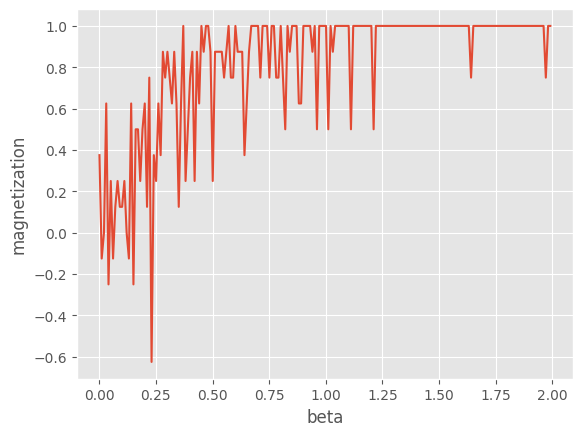

In [165]:
# 温度パラメータを変化させた時
np.random.seed(111)
beta = np.arange(0.001, 2 , 0.01)
J = 1
h = 1
magnetization = []
for b in beta:
    # 正方格子の初期化
    lattice = test_lattice()
    lattice = one_step(lattice, b , J , h)
    m = compute_magnetization(lattice)
    magnetization.append(m)
plt.plot(beta, magnetization)
plt.xlabel("beta")
plt.ylabel("magnetization")
plt.show()


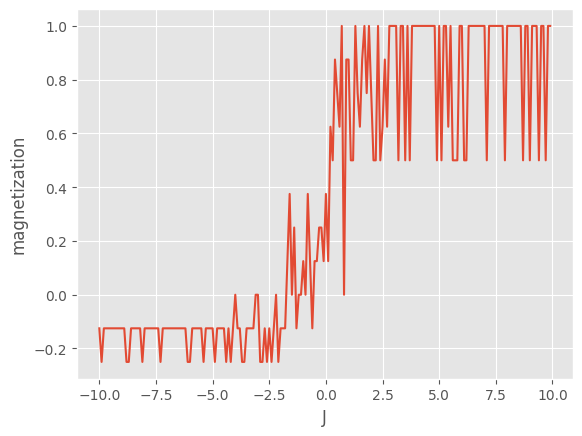

In [166]:
# 相互作用パラメータを変化させた時
np.random.seed(111)
beta = 0.5
J = np.arange(-10, 10 , 0.1)
h = 1
magnetization = []
for jj in J:
    # 正方格子の初期化
    lattice = test_lattice()
    lattice = one_step(lattice, beta , jj , h)
    m = compute_magnetization(lattice)
    magnetization.append(m)
plt.plot(J, magnetization)
plt.xlabel("J")
plt.ylabel("magnetization")
plt.show()

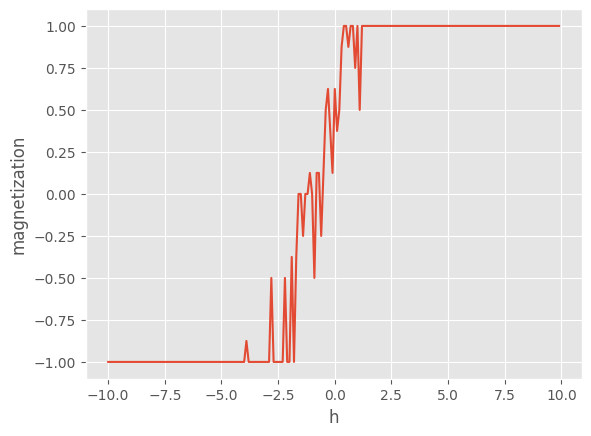

In [167]:
# 磁場パラメータを変化させた時
np.random.seed(111)
beta = 1
J = 1
h = np.arange(- 10, 10 , 0.1)
magnetization = []
for hh in h:
    # 正方格子の初期化
    lattice = test_lattice()
    lattice = one_step(lattice, beta , J , hh)
    m = compute_magnetization(lattice)
    magnetization.append(m)
plt.plot(h, magnetization)
plt.xlabel("h")
plt.ylabel("magnetization")
plt.show()

それでは大きな正方格子で計算を繰り返してみましょう．

In [170]:
# 2次元正方格子の作成をする関数，引数nは格子のサイズ
def create_lattice(n):
    lattice = np.random.choice([-1, 1], size=(n, n))
    return lattice

In [171]:
n = 32
lattice = create_lattice(n)
m = compute_magnetization(lattice)
print("初期状態:")
print(lattice)
print(f"磁化率: {m}")

初期状態:
[[ 1  1  1 ... -1  1 -1]
 [ 1  1 -1 ...  1  1  1]
 [-1 -1  1 ...  1 -1  1]
 ...
 [-1  1 -1 ...  1 -1  1]
 [ 1 -1  1 ...  1  1 -1]
 [ 1  1  1 ...  1 -1  1]]
磁化率: 0.001953125


In [172]:
# 繰り返し格子の更新を行い磁化率の推移を見る関数
def compute_magnetization_transition(lattice, beta , J , h, n_steps):
    magnetization_transition = []
    for i in range(n_steps):
        lattice = one_step(lattice, beta , J , h)
        m = compute_magnetization(lattice)
        magnetization_transition.append(m)
    return magnetization_transition

In [173]:
beta = 0.440687
J = 1
h = 0.25

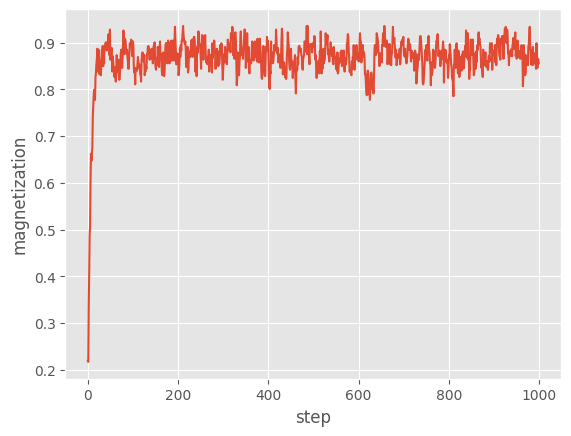

In [174]:
n_steps = 1000
np.random.seed(111)
magnetization_transition = compute_magnetization_transition(lattice, beta , J , h, n_steps)
plt.plot(range(n_steps), magnetization_transition)
plt.xlabel("step")
plt.ylabel("magnetization")
plt.show()

これで磁化率が計算できました．

以上でギブスサンプリングの説明を終わります．

## 3回目(6/21):『これならわかる機械学習入門』11章